In [1]:
import madrigalWeb.madrigalWeb
import pylab
import matplotlib.cm
import numpy
import h5py
import datetime
import dateutil.parser
import calendar
import re
%matplotlib inline

In [2]:
#CHANGE ME
user_fullname = "Student Example"
user_email = "isr.summer.school@gmail.com"
user_affiliation = "ISR Summer School 2022"

maddat = madrigalWeb.madrigalWeb.MadrigalData('http://cedar.openmadrigal.org/')

In [3]:
# instrument codes for Millstone Hill
instcodes={'MHO':30}

In [4]:
# start time
st=datetime.datetime(2022, 3, 30, 0,0)
et=datetime.datetime(2022, 3, 31, 0,0)

expList = maddat.getExperiments(instcodes['MHO'], 
                                st.year, st.month, st.day, st.hour, st.minute, st.second, 
                                et.year, et.month, et.day, et.hour, et.minute, et.second)
for exp in expList:
    print(exp)

id: 100239878
realUrl: http://cedar.openmadrigal.org/showExperiment/?experiment_list=100239878
url: http://cedar.openmadrigal.org/madtoc/experiments5/2022/mlh/30mar22
name: CME Experiment
siteid: 10
sitename: CEDAR
instcode: 30
instname: Millstone Hill IS Radar
startyear: 2022
startmonth: 3
startday: 30
starthour: 16
startmin: 51
startsec: 49
endyear: 2022
endmonth: 3
endday: 30
endhour: 23
endmin: 59
endsec: 16
isLocal: True
madrigalUrl: http://cedar.openmadrigal.org/
PI: Phil Erickson
PIEmail: perickson@haystack.mit.edu
uttimestamp: 1653996166
access: 2
Madrigal version: 3.2

id: 100237860
realUrl: http://cedar.openmadrigal.org/showExperiment/?experiment_list=100237860
url: http://cedar.openmadrigal.org/madtoc/experiments5/2022/mlh/30mar22p
name: High resolution F2 Peak Density and Hmax (From Plasma Line)
siteid: 10
sitename: CEDAR
instcode: 30
instname: Millstone Hill IS Radar
startyear: 2022
startmonth: 3
startday: 30
starthour: 16
startmin: 51
startsec: 49
endyear: 2022
endmonth: 

In [5]:
# select experiment (regular ion line parameters)
for thisExp in expList:
    if re.match(thisExp.name, 'CME Experiment'):
        break
print('Selecting: %s' % (thisExp.name))

Selecting: CME Experiment


In [6]:
# survey all experiment files available
fileList = maddat.getExperimentFiles(thisExp.id)
thisFile=None
for file in fileList:
    print(file.kindatdesc)

Gridded data fitted to a uniform spatial and temporal grid - useful for modellers
Derived vector ion velocities
Combined basic parameters file - all antennas and modes
Zenith single-pulse basic parameters
Zenith alternating-code basic parameters
MISA (steerable) single-pulse basic parameters


In [7]:
# Select the correct experiment file (All antennas)
fileList = maddat.getExperimentFiles(thisExp.id)
thisFile=None
for file in fileList:
    if re.match('Combined basic parameters',file.kindatdesc):
        print('Using: %s' % (file))
        thisFile=file
        break

Using: name: /opt/cedar3/experiments5/2022/mlh/30mar22/mlh220330g.003.hdf5
kindat: 3410
kindatdesc: Combined basic parameters file - all antennas and modes
category: 1
status: Final
permission: 0
expId: 100239878
doi: https://w3id.org/cedar?experiment_list=experiments5/2022/mlh/30mar22&file_list=mlh220330g.003.hdf5



In [8]:
# Download the file (should end up in this folder)       
filename=thisFile.name
outfilename=thisFile.name.split('/')[-1]
result = maddat.downloadFile(filename,outfilename, user_fullname, user_email, user_affiliation, 'hdf5')

In [9]:
# Load file and get data table
hz = h5py.File(outfilename,'r')
hztl = hz['Data']['Table Layout']

In [10]:
# Survey the radar pulse lengths in this experiment
print('Unique pulse lengths in sec: %s' % (list(set(hztl['pl']))))

Unique pulse lengths in sec: [0.00128, 0.00048]


In [11]:
# antenna codes for Millstone Hill
antcodes={'Zenith':32,
           'MISA':31}

In [12]:
# waveform mode types for Millstone Hill
modecodes={'Uncoded480':115,
           'AC_480_16baud_strong':97}

In [13]:
# Select the 480 usec uncoded pulse from the zenith at the desired times
indx = numpy.where(numpy.logical_and(hztl['mdtyp'] == modecodes['Uncoded480'],
                                    hztl['kinst'] == antcodes['Zenith']))[0]
hztl = hztl[indx]

In [14]:
# Build a time array
ut = 0.5*(hztl['ut1_unix'] + hztl['ut2_unix'])
dut = numpy.array([datetime.datetime.utcfromtimestamp(uut) for uut in ut])

In [15]:
# Electron density:
# Construct X and Y meshgrid arrays for 2D plot and extract data for plotting
tcount = len(set(ut))
X = numpy.array(hztl['gdalt'])
X = X.reshape(tcount,-1)
Y = numpy.array(dut)
Y = Y.reshape(tcount,-1)

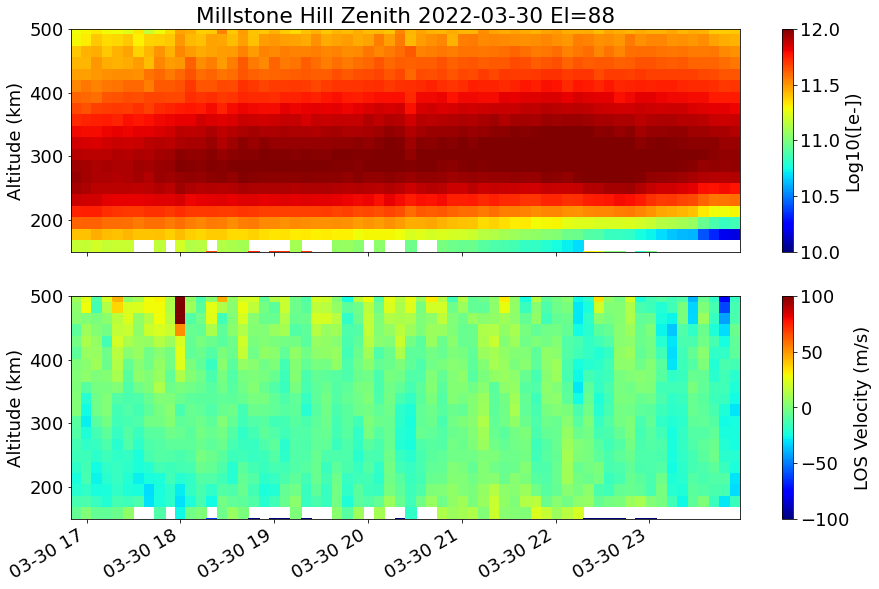

In [16]:
# Make double panel figure:
# Electron density, LOS velocity

pylab.rcParams['figure.figsize']=(15,10)
pylab.rcParams['font.size']=18
f,ax = pylab.subplots(2,1,sharex=True)

Z = numpy.log10(hztl['ne'])
Z = Z.reshape(X.shape)
am = ax[0].pcolor(Y, X, Z, vmin=10, vmax=12, cmap='jet')
ax[0].set_ylim(150,500)
f.colorbar(am, ax=ax[0], label='Log10([e-])')
ax[0].set_ylabel('Altitude (km)')
ax[0].set_title('Millstone Hill Zenith %s El=%.0f' % (dut[0].strftime('%Y-%m-%d'),
                                                    hztl['el1'][0]))

Z = hztl['vo']
Z = Z.reshape(X.shape)
am = ax[1].pcolor(Y, X, Z, vmin=-100, vmax=100, cmap='jet')
ax[1].set_ylim(150,500)
f.colorbar(am, ax=ax[1], label='LOS Velocity (m/s)')
ax[1].set_ylabel('Altitude (km)')

f.autofmt_xdate()

In [17]:
# Re-load file and get data table
hz = h5py.File(outfilename,'r')
hztl = hz['Data']['Table Layout']

In [18]:
# Select the 480 usec uncoded pulse from the MISA at the desired times
indx = numpy.where(numpy.logical_and(hztl['mdtyp'] == modecodes['Uncoded480'],
                                    hztl['kinst'] == antcodes['MISA']))[0]
hztl = hztl[indx]

In [19]:
# Build a time array
ut = 0.5*(hztl['ut1_unix'] + hztl['ut2_unix'])
dut = numpy.array([datetime.datetime.utcfromtimestamp(uut) for uut in ut])

In [20]:
set(hztl['az1'])

{-45.11, -45.1, -45.09, -45.08, -45.07, -45.06, -45.05}

In [21]:
# Electron density:
# Construct X and Y meshgrid arrays for 2D plot and extract data for plotting
tcount = len(set(ut))
X = numpy.array(hztl['gdalt'])
X = X.reshape(tcount,-1)
Y = numpy.array(dut)
Y = Y.reshape(tcount,-1)

/var/folders/fv/q7qf8rjn6zdd37k3vttxspjw0000gp/T/ipykernel_36994/3024634079.py:10: UserWarning: The input coordinates to pcolor are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolor.
  am = ax[0].pcolor(Y, X, Z, vmin=9, vmax=12, cmap='jet')
/var/folders/fv/q7qf8rjn6zdd37k3vttxspjw0000gp/T/ipykernel_36994/3024634079.py:20: UserWarning: The input coordinates to pcolor are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolor.
  am = ax[1].pcolor(Y, X, Z, vmin=-100, vmax=100, cmap='jet')


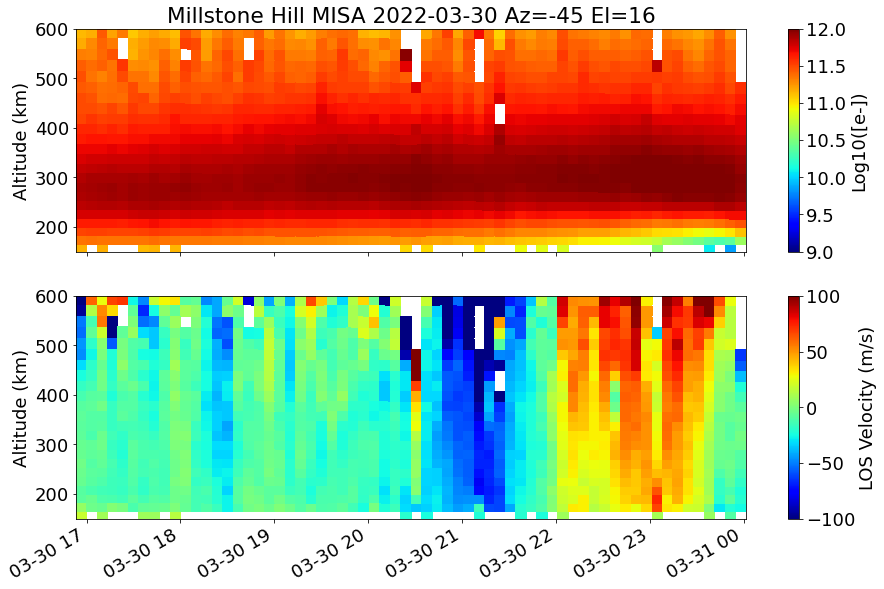

In [22]:
# Make double panel figure:
# Electron density, LOS velocity

pylab.rcParams['figure.figsize']=(15,10)
pylab.rcParams['font.size']=18
f,ax = pylab.subplots(2,1,sharex=True)

Z = numpy.log10(hztl['ne'])
Z = Z.reshape(X.shape)
am = ax[0].pcolor(Y, X, Z, vmin=9, vmax=12, cmap='jet')
ax[0].set_ylim(150,600)
f.colorbar(am, ax=ax[0], label='Log10([e-])')
ax[0].set_ylabel('Altitude (km)')
ax[0].set_title('Millstone Hill MISA %s Az=%.0f El=%.0f' % (dut[0].strftime('%Y-%m-%d'),
                                                              hztl['az1'][0],
                                                              hztl['el1'][0]))

Z = hztl['vo']
Z = Z.reshape(X.shape)
am = ax[1].pcolor(Y, X, Z, vmin=-100, vmax=100, cmap='jet')
ax[1].set_ylim(150,600)
f.colorbar(am, ax=ax[1], label='LOS Velocity (m/s)')
ax[1].set_ylabel('Altitude (km)')

f.autofmt_xdate()

# Questions

1. What happened at 21 UTC and 22-23 UTC?

2. What was the magnetic/auroral activity during these periods?

3. What could be analyzed by combining two different line of sight velocity directions (Zenith, MISA at -45 az / 16 el)?  How far are these points apart and how would that effect combined analysis of the two directions for this experiment?